In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from math import e, factorial
from matplotlib.pyplot import imshow
from PIL import Image

In [2]:
def rng_tester(rng):
    """
    Function to (visually) test pseudo-random number generators.
    By plotting a black and white picture with randomized black and white pixels by a given rng.
    and by plotting a histogram of 1 million values provided by a given rng.
    :param rng: rng as generator object
    """
    img = Image.new('1', (500, 500))
    pixels = img.load()
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            p_random = next(rng)
            pixels[x, y] = 0 if p_random < 0.5 else 1

    imshow(img)
    plt.title('black & white test')
    plt.show()
    plt.title('histogram test')
    plt.hist([next(rng) for i in range(1_000_000)])
    plt.show()

#### Middle square method
Middle square method as provided on Canvas.

In [3]:
def msqm(seed):
    while True:
        left = True
        seed = seed ** 2
        while len(str(seed)) > 4:
            if left:
                seed = int(str(seed)[1:])
                left=False
            else:
                seed = int(str(seed)[:-1])
                left=True
        yield seed/10000

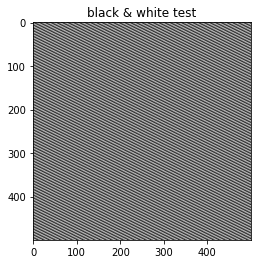

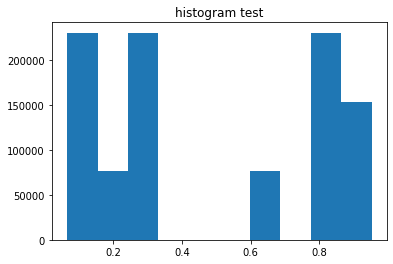

In [4]:
rng_tester(msqm(123456789))

The black and white picture doesn't have alot of noise and the histogram has no uniform distribution, suggesting bad prng values as expected.

#### Linear congruential generator

In [5]:
def lcg(seed, m=19993, a=15005, c=8371):
    """
    linear congruential generator (LCG).
    LCG w
    Param rules:
        c and m are relative primes. (no gcd bigger than 1)
        a - 1 is dividable by all primefactors of m
        a - 1 is a multiple of 4 if m is a multiple of 4
    args:
        seed: seed used to generate pseudo-random number.
        m: the modulus
        a: the multiplier
        c: the increment
    """
    while True: # while True loop instead of yield from ... to avoid recursion depth error.
        seed = (a * seed + c) % m  # linear formula to update the seed.
        yield seed / m  # yield the pseudo-random number.

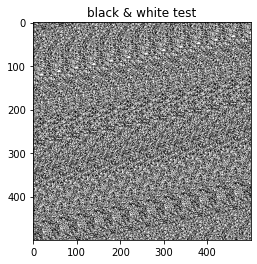

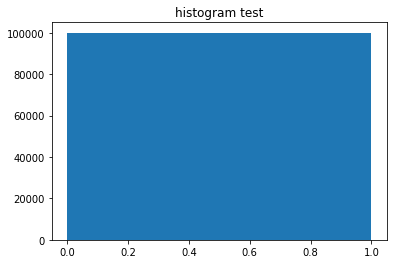

In [6]:
rng_tester(lcg(12345))

The black and white picture of the linear congruential generator looks alot better than the middle square method but there are still visible patterns.
The histogram looks uniform.

#### Lagged fibbonaci generator

In [7]:
def lfg(seed, j=24, k=55, m=2, binary_operation=lambda x, y: x + y):
    """
    :param seed: seed used to generate adjusted seed using lcg(seed).
    :param j: lag.
    :param k: length adjusted seed.
    :param m: % m
    :param binary_operation: Either addition, subtraction, multiplication or X-OR.
    :return: pseudo-random number
    """
    # LFG needs (pseudo) random numbers as initial seed to perform well.
    # For this reason the passed seed is used to create a pseudo-random initial seed using the passed seed.
    rng = lcg(seed)
    seed=[next(rng) for i in range(k)]
    while True:
        new_value = binary_operation(seed[j-1], seed[k-1]) % m # get the new value by applying the binary operator on the lagged values: PRN => (Xj <> seed Xk) % m
        # remove the first value and append the new value to shift the sequence to the left losing the left most element.
        seed.pop(0)
        seed.append(new_value)
        yield new_value / m # yield pseudo random number.

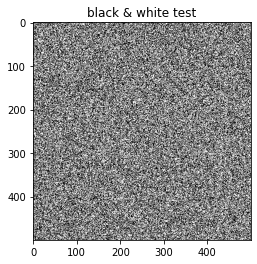

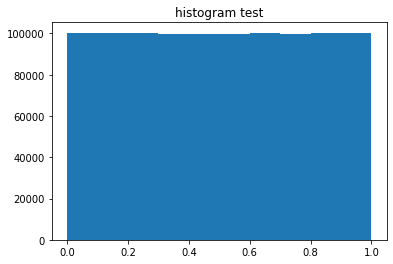

In [8]:
rng_tester(lfg(seed=12345))

The black and white picture of the lagged Fibonacci generator looks better than LCG with uniform noise without any apparent pattern.
And the histogram seems to have a uniform distribution.

## Monte-Carlo simulation

Load in win draw lose probabilities and create a function to choose a match-result based on the home team, out team and their result probabilities.

In [9]:
df_wdl = pd.read_csv("wdl_probabilities.csv", index_col=[0, 1])

In [10]:
df_wdl

win  draw  lose
home away                  
AJA  FEY   0.65  0.17  0.18
     PSV   0.54  0.21  0.25
     FCU   0.74  0.14  0.12
     WIL   0.78  0.13  0.09
FEY  AJA   0.30  0.21  0.49
     PSV   0.37  0.24  0.39
     FCU   0.51  0.22  0.27
     WIL   0.60  0.21  0.19
PSV  AJA   0.39  0.22  0.39
     FEY   0.54  0.22  0.24
     FCU   0.62  0.20  0.18
     WIL   0.62  0.22  0.16
FCU  AJA   0.25  0.14  0.61
     FEY   0.37  0.23  0.40
     PSV   0.29  0.24  0.47
     WIL   0.52  0.23  0.25
WIL  AJA   0.17  0.18  0.65
     FEY   0.20  0.26  0.54
     PSV   0.23  0.24  0.53
     FCU   0.37  0.25  0.38

In [11]:
def wld_chances(home_team, away_team):
    """
    :param home_team: string home team
    :param away_team:  string away team
    :return: match result from the home team's perspective
    """
    p_cumulative = 0
    p_random = next(RNG) # between 0 and 1
    for result, p in df_wdl.loc[home_team].loc[away_team].iteritems(): # iterate through match results and their probabilities
        # if cumulative probability is bigger than p random the current option is the 'weighted random sampled' result.
        p_cumulative += p
        if p_random <= p_cumulative:
            return result

#### Poisson
Load in average goals csv and create a function applying poisson distribution to decide the n of goals for the home and out team returning the match result based on number of goals.

In [12]:
df_average_goals = pd.read_csv('average_goals.csv', delimiter=';')

In [13]:
df_average_goals

,HS,HC,AS,AC
AJA,3.2,0.9,3.1,0.6
FEY,2.4,1.1,2.2,0.8
PSV,2.1,0.7,1.8,1.3
FCU,1.9,1.2,3.0,2.4
WIL,1.4,1.7,1.0,1.5


In [14]:
def poisson(home_team, away_team):
    """
    :param home_team: string home team
    :param away_team:  string away team
    :return: match result from the home team's perspective
    """
    def decide_goals(expected_goals):
        """
        Nested function to decide the goals based on Poisson distribution.
        :param expected_goals: expected amount of goals a team is expected to make against another team.
        :return: goals made based on expected goals and weighted sampling using Poisson distribution
        """
        p_cumm = 0
        p_random = next(RNG)
        n_goals = 0
        while True:
            p_cumm += ((expected_goals ** n_goals) * (e**-expected_goals))/factorial(n_goals) # use poisson to get probability of n goals

            if p_random <= p_cumm: # if the cumulative probability is bigger then the prng the current amount of goals is returned
                return n_goals
            # otherwise, get the probability of the n goals + 1
            n_goals += 1

    home_goals = decide_goals((df_average_goals.loc[home_team]["HS"] + df_average_goals.loc[away_team]["AC"]) / 2) # expected goals = (home HS + away AC) / 2
    out_goals =  decide_goals((df_average_goals.loc[home_team]["HC"] + df_average_goals.loc[away_team]["AS"]) / 2) # expected goals = (home HC + away AS) / 2
    # check if it's a win, draw or lose (from the home team's perspective).
    if home_goals > out_goals:
        return "win"
    elif home_goals == out_goals:
        return "draw"
    else:
        return "lose"

Function to simulate a single competition where every team plays against every other team resulting in a competition where every team plays home and away from each other.

In [15]:
def competition(match_decider, teams):
    """

    :param match_decider: function that returns a match result (win, lose or draw). (function options are: wld_chances and poisson)
    :param teams: list of all the teams.
    :return: Ranking of the competiton
    """
    point_increments = {
                        "win" : (3,0),
                        "draw": (1,1),
                        "lose": (0,3)
                        }
    scoreboard = pd.Series(dict.fromkeys(teams,0),name='score')
    # for all teams
    for home_team in teams:
        # play against all others
        for out_team in filter(lambda team: team is not home_team,teams):
            # result of the match relative from the home team
            match_result = match_decider(home_team, out_team)
            # amount of points home and out team get
            home_points, out_points = point_increments[match_result]
            # update points
            scoreboard[home_team] += home_points
            scoreboard[out_team] += out_points
    # Dense ranking meaning multiple clubs can share a rank, ranks are always incremented and not skipped
    # ex: 1, 2, 2, 3, 4 is a valid ranking but 1, 2, 2, 4, 5 is not.
    return scoreboard.rank(ascending=False, method='dense').astype('int')

Function to simulate a competition N times and get probability of each result based on the N simulated competitions.

In [16]:
def monte_carlo_sim(n_competitions, match_decider):
    # set up a dataframe to keep track of the ranking.
    teams = ["AJA", "FEY", "PSV", "FCU", "WIL"]
    total_leaderboard = pd.DataFrame(index=teams, columns=[f"rank_{i}" for i in range(1,6)], data=[[0 for i in range(5)] for j in range(5)])
    # iterate through n completions.
    for i in range(n_competitions):
        # play a competition and iterate through the ranking.
        for ranking in competition(match_decider, teams).iteritems():
            club, rank = ranking
            # update the amount of times a club gotten this rank.
            total_leaderboard.loc[club].loc[f"rank_{rank}"] += 1
    # return the chance of each rank for each club.
    return total_leaderboard/n_competitions

Function to turn probabilities into % and a string format to get the percent chance on table.

In [17]:
prob_to_perc = lambda df: df.apply(lambda x: round(x*100,2)).astype(str).apply(lambda x: x + '%')

In [18]:
n_competitions = 5000

Simulate n competitions with results according to Win Draw Lose chances and according to Poisson using expected goals.

In [19]:
RNG = lfg(seed=12345) # reset RNG
result_wdl = monte_carlo_sim(n_competitions, wld_chances) # monte carlo simulation using W/D/L probabilities to determine ach competition result.

In [20]:
RNG = lfg(seed=12345) # reset RNG
result_poisson = monte_carlo_sim(n_competitions, poisson) # monte carlo simulation using poisson to determine each competition result.

Percent chance to end a certain rank according to W/D/L probabilities.

In [21]:
prob_to_perc(result_wdl)

,rank_1,rank_2,rank_3,rank_4,rank_5
AJA,61.34%,26.08%,9.04%,2.92%,0.62%
FEY,13.76%,29.66%,31.92%,17.92%,6.74%
PSV,29.1%,36.12%,22.96%,9.62%,2.2%
FCU,4.6%,16.12%,30.08%,32.82%,16.38%
WIL,1.56%,7.34%,19.58%,37.84%,33.68%


Percent chance to end a certain rank according to average goals using Poisson distribution.

In [22]:
prob_to_perc(result_poisson)

,rank_1,rank_2,rank_3,rank_4,rank_5
AJA,57.08%,26.34%,11.72%,3.9%,0.96%
FEY,23.68%,33.32%,24.58%,14.16%,4.26%
PSV,15.6%,26.28%,29.3%,21.54%,7.28%
FCU,12.28%,22.68%,28.82%,25.36%,10.86%
WIL,2.42%,8.36%,20.26%,36.56%,32.4%


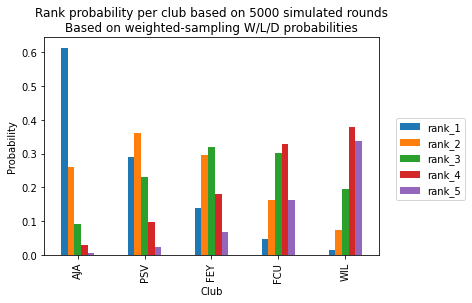

In [23]:
result_wdl.sort_values(by='rank_1', ascending=False).plot.bar() # sort values by first rank to order x-axis by frequency of first-rank for each club.
plt.title(f'Rank probability per club based on {n_competitions} simulated rounds\n'
          'Based on weighted-sampling W/L/D probabilities')
plt.xlabel('Club')
plt.ylabel('Probability')
plt.legend(loc=(1.05, .25))
plt.show()

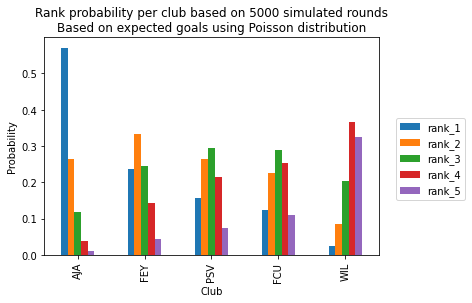

In [24]:
result_poisson.sort_values(by='rank_1', ascending=False).plot.bar() # sort values by first rank to order x-axis by frequency of first-rank for each club.
plt.title(f'Rank probability per club based on {n_competitions} simulated rounds\n'
          'Based on expected goals using Poisson distribution')
plt.xlabel('Club')
plt.ylabel('Probability')
plt.legend(loc=(1.05, .25))
plt.show()